In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-insurance-lead-prediction-raw-data/Health Insurance Lead Prediction Raw Data.csv


#  Loading Libraries

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import VarianceThreshold

sns.set_style('darkgrid',{"grid.color": ".6", "grid.linestyle": ":"})
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# Loading Dataset

In [3]:
insurance_data=pd.read_csv('/kaggle/input/health-insurance-lead-prediction-raw-data/Health Insurance Lead Prediction Raw Data.csv')

In [4]:
insurance_data.shape

(50882, 14)

In [5]:
insurance_data.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [6]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [7]:
insurance_data.drop('ID',axis=1,inplace=True)

# Handling missing value of categorical features

In [8]:
insurance_data['Holding_Policy_Duration'].unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [9]:
insurance_data['Holding_Policy_Duration'].replace({'14+':15},inplace=True)

In [10]:
insurance_data['Holding_Policy_Duration'].fillna(0,inplace=True)

In [11]:
insurance_data['Holding_Policy_Duration']=pd.to_numeric(insurance_data['Holding_Policy_Duration'])

In [12]:
insurance_data['Holding_Policy_Type'].unique()

array([ 3., nan,  1.,  4.,  2.])

In [13]:
insurance_data['Holding_Policy_Type'].fillna(0,inplace=True)

In [14]:
insurance_data['Health Indicator'].unique()

array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

In [15]:
insurance_data['Health Indicator'].fillna('X0',inplace=True)

In [16]:
insurance_data['Region_Code'].nunique()

5316

In [17]:
insurance_data.drop('Region_Code',inplace=True,axis=1)

In [18]:
insurance_data['City_Code'].nunique()

36

In [19]:
insurance_data['Reco_Policy_Cat'].nunique()

22

In [20]:
insurance_data[['City_Code','Health Indicator']].nunique()

City_Code           36
Health Indicator    10
dtype: int64

In [21]:
cat_var=['City_Code','Health Indicator']

# Summary Statistics

In [22]:
insurance_data.describe()

,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000
mean,44.856275,42.738866,3.706379,1.468417,15.115188,14183.950069,0.239947
std,17.310271,17.319375,4.766053,1.434988,6.340663,6590.074873,0.427055
min,18.000000,16.000000,0.000000,0.000000,1.000000,2280.000000,0.000000
25%,28.000000,27.000000,0.000000,0.000000,12.000000,9248.000000,0.000000
50%,44.000000,40.000000,2.000000,1.000000,17.000000,13178.000000,0.000000
75%,59.000000,57.000000,6.000000,3.000000,20.000000,18096.000000,0.000000
max,75.000000,75.000000,15.000000,4.000000,22.000000,43350.400000,1.000000


# Data visualization

In [ ]:
sns.pairplot(insurance_data,kind='reg',diag_kind='kde',hue='Response',aspect=2)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(insurance_data['Response'])
plt.show()

## It depicts almost 1 out of 4 th of the person is the right lead for the agent for doing business  

In [ ]:
sns.catplot(data=insurance_data,y='Holding_Policy_Duration',x='Upper_Age',col='Response',aspect=2,height=5,kind='point',sharey=False,color='Green')
plt.xticks(np.arange(0,100,20))
plt.show()

## It shows the positive relation in upper age and holding policy duration

In [ ]:
sns.catplot(data=insurance_data,y='Holding_Policy_Type',x='Upper_Age',col='Response',aspect=2,height=5,kind='point',sharey=False,color='Green')
plt.xticks(np.arange(0,100,20))
plt.show()

## It shows the positive relation in upper_age and holding_policy_type

In [ ]:
cat_variables=['Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health Indicator']

In [ ]:
def automate_catplot(x_value,y_value,):
    for cat_col_name in cat_variables:
        sns.catplot(data=insurance_data,x=x_value,y=y_value,col='Response',row=cat_col_name,kind='violin',aspect=2,height=6,sharex=False,sharey=False)
        plt.show()    

In [ ]:
automate_catplot('Holding_Policy_Type','Upper_Age')

## Holding_policy_type has a significant association with upper_age and response,and accommodation_type,is_spouse and health_indicator all play major roles.

In [ ]:
automate_catplot('Reco_Policy_Cat','Upper_Age')

## Reco policy cat has a significant association with upper age and response,and accommodation_type,is_spouse and health_indicator all play major roles.

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(insurance_data['Upper_Age'],insurance_data['Reco_Policy_Premium'])
ax[1].scatter(insurance_data['Lower_Age'],insurance_data['Reco_Policy_Premium'])
ax[0].set_xlabel('Upper Age')
ax[1].set_xlabel('Lower Age')
ax[0].set_ylabel('Reco Policy Premium')
ax[0].set_title('Upper Ages v/s Reco Policy Premium')
ax[1].set_title('Lower Ages v/s Reco Policy Premium')
plt.show()


In [ ]:
sns.catplot(data=insurance_data,y='Reco_Policy_Premium',x='Upper_Age',col='Response',aspect=2,height=5)
plt.xticks(np.arange(0,100,20))
plt.show()

## It shows the positive relation between upper age feature and Reco policy premium feature

In [ ]:
sns.catplot(data=insurance_data,y='Reco_Policy_Premium',x='Lower_Age',col='Response',aspect=2,height=5)
plt.xticks(np.arange(0,100,20))
plt.show()

## It clearly reveals that higher ages are beneficial, but lower ages are inconsistent, hence I am eliminating them from the dataset

In [ ]:
insurance_data.drop('Lower_Age',1,inplace=True)

In [ ]:
sns.kdeplot(data=insurance_data,y='Holding_Policy_Duration',x='Reco_Policy_Cat',hue='Response')
plt.show()

# insurance company has more products for long term policy holder

In [ ]:
automate_catplot('Holding_Policy_Duration','Reco_Policy_Premium')

In [ ]:
sns.catplot(data=insurance_data,x='Holding_Policy_Duration',y='Reco_Policy_Premium',col='Response',row='Health Indicator',kind='swarm',aspect=2,sharey=False,sharex=False)
plt.show()

# In health indicator X7,X8 and X9 categories of health indicator are least important and it does not give any insights 

In [ ]:
sns.catplot(data=insurance_data,x='Holding_Policy_Type',y='Reco_Policy_Cat',col='Response',kind='swarm',sharey=False,aspect=2)
plt.show()

## It showcases the relevance of holding_policy_type and reco_policy_cat in which 1,2, and 4 key holding_policy_type categories are being shown.

In [ ]:
sns.catplot(data=insurance_data,x='Holding_Policy_Type',y='Reco_Policy_Cat',col='Response',row='Health Indicator',kind='swarm',sharey=False,sharex=False,aspect=2)
plt.show()

## It emphasises the significance of holding_policy_type and reco_policy_cat 1- 4 categories in health indicator, but X7,X8, and X9 categories of health indicator cannot provide any information.

In [ ]:
sns.catplot(data=insurance_data,x='Holding_Policy_Type',y='Reco_Policy_Premium',col='Response',kind='swarm',sharey=False,aspect=2)
plt.show()

## Whenever a policy is purchased, a discount is available to the customer  

In [ ]:
sns.catplot(data=insurance_data,x='Reco_Policy_Cat',y='Reco_Policy_Premium',col='Response',kind='swarm',sharey=False,aspect=2)
plt.show()

## When we leverage the recognisable factor of response features, there is a great diversity in the distribution of reco policy cat and reco policy premium.

In [ ]:
for col_name in cat_variables[:-2]:
    sns.catplot(data=insurance_data,x='Reco_Policy_Cat',y='Reco_Policy_Premium',row='Response',col=col_name,kind='swarm',sharey=False,sharex=False,aspect=2)
    plt.show()

## The response feature has been a fundamental differentiator between reco_policy_cat and reco_policy_premium. When the response is 1, it clearly displays.

In [ ]:
sns.catplot(data=insurance_data,x='Reco_Policy_Cat',y='Reco_Policy_Premium',hue='Response',col='Health Indicator',kind='swarm',sharey=False,sharex=False,aspect=2,col_wrap=2)
plt.show()

In [ ]:
sns.catplot(data=insurance_data,x='Reco_Policy_Cat',y='Reco_Policy_Premium',hue='Response',col='Health Indicator',kind='box',sharey=False,sharex=False,aspect=2,col_wrap=2)
plt.show()

## When we put Reco_Policy_cat and Reco_Policy_premium into plots for analysis, categories X7-X9 of the health indicator are the least important.

# **Insights** : " what we ve got from data visualization " 

# 1. *response or target variables* 

# When i created a countplot of the response variables, I found that the positive lead out of the total is around 1/4

# 2. *upper_age v/s reco_policy_premium*

# Albeit sometimes, there is a positive association between the two

# 3. *upper_age v/s holding_policy_type or holding_policy_duration*

# It illustrates a positive link between upper_age and holding_policy_type or holding_policy_duration

# holding_policy_type is significantly related to upper_age and response, and accommodation_type, is_spouse, and health_indicator all play important roles

# 4. *upper_age v/s reco_policy_cat*

# reco_policy_cat is associated with upper_age and response, and accommodation_type, is_spouse, and health_indicator all play important roles.

# 5. *holding_policy_duration v/s reco_policy_premium*

# When we make a graph of holding_policy_duration and reco_policy_premium, the categories of health indicators X7,X8, and X9 are the least relevant and provide no insights.

# 6. *holding_policy_type v/s reco_policy_cat*

# It demonstrates the importance of holding_policy_type and reco_policy_cat by displaying 1, 2, and 4 important holding policy type categories

# It emphasises the importance of the holding_policy_type and reco_policy_cat 1- 4 categories in the health indicator, while the X7,X8, and X9 health indicator categories do not give any information.

# 7. *holding_policy_type v/s holding_policy_premium*

# Whenever a policy is purchased, a discount is available to the customer  

# 8. *reco_policy_cat v/s holding_policy_duration*

# insurance company has more products for long term policy holder

# 9. *reco_policy_cat v/s reco_policy_premium*

# When we leverage the recognisable factor of response features, there is a great diversity in the distribution of reco_policy_cat and reco_policy_premium.

# The response feature has been a fundamental differentiator between reco_policy_cat and reco_policy_premium. When the response is 1, it clearly displays

# When we put reco_policy_cat and reco_policy_premium into plots for analysis, categories X7-X9 of the health indicator are the least important.

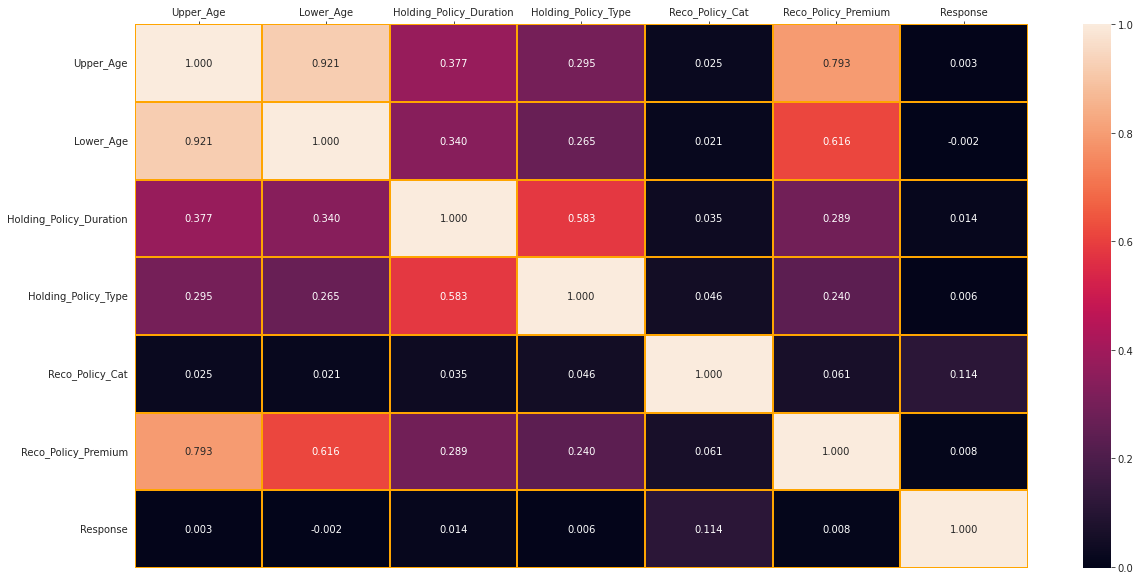

In [23]:
ax=sns.heatmap(insurance_data.corr(),annot=True,fmt=".3f",linewidth=.10,linecolor='orange')
ax.set(xlabel="",ylabel="")
ax.xaxis.tick_top()
plt.show()

# Remove features which is causing leakage


In [24]:
insurance_data.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,Rented,Individual,36,36,No,X1,15.0,3.0,22,11628.0,0
1,C5,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.0,0
2,C5,Owned,Individual,32,32,No,X0,1.0,1.0,19,7450.0,1
3,C24,Owned,Joint,52,48,No,X1,15.0,3.0,19,17780.0,0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [25]:
drop_feature=['Holding_Policy_Type']
insurance_data.drop(drop_feature,inplace=True,axis=1)

# Spiliting data into Features variables in X and Target variable in y

In [26]:
X=insurance_data.copy()
y=X.pop('Response')

In [27]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

# Category Encoder

In [28]:
encoder=MEstimateEncoder(cols=cat_var,m=10,randomized=1).fit(X_train,y_train)

In [29]:
numeric_data=encoder.transform(X_train)

In [30]:
numeric_data.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium
49279,0.247375,Rented,Individual,24,24,No,0.243168,3.0,4,9648.0
38608,0.245460,Rented,Individual,73,73,No,0.242838,9.0,21,17524.0
48103,0.216710,Owned,Individual,70,70,No,0.242838,8.0,17,17760.0
15708,0.237293,Owned,Individual,49,49,No,0.235257,3.0,13,16276.0
48954,0.230596,Owned,Joint,59,48,Yes,0.235257,15.0,9,27072.0


In [31]:
encoder_test=MEstimateEncoder(cols=cat_var,m=5,randomized=1).fit(X_test,y_test)

In [32]:
numeric_data_test=encoder.transform(X_test)

In [33]:
numeric_data_test.head(10)

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium
25198,0.249764,Owned,Individual,48,48,No,0.227717,2.0,22,16666.0
30068,0.229616,Rented,Individual,31,31,No,0.237620,0.0,18,9856.0
22034,0.244489,Owned,Individual,54,54,No,0.243168,0.0,21,12996.0
7696,0.237272,Rented,Individual,51,51,No,0.242838,2.0,8,11960.0
38105,0.249764,Rented,Joint,34,32,Yes,0.240548,3.0,10,16296.0
17100,0.237293,Owned,Individual,57,57,No,0.240548,10.0,3,18788.0
49776,0.258906,Rented,Individual,25,25,No,0.237620,2.0,22,6510.0
17685,0.237272,Rented,Individual,20,20,No,0.235257,0.0,16,6680.0
12432,0.226629,Owned,Joint,56,17,No,0.243168,2.0,9,20966.4
14982,0.237272,Owned,Individual,51,51,No,0.240548,15.0,18,10818.0


In [34]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35617 entries, 49279 to 25871
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                35617 non-null  float64
 1   Accomodation_Type        35617 non-null  object 
 2   Reco_Insurance_Type      35617 non-null  object 
 3   Upper_Age                35617 non-null  int64  
 4   Lower_Age                35617 non-null  int64  
 5   Is_Spouse                35617 non-null  object 
 6   Health Indicator         35617 non-null  float64
 7   Holding_Policy_Duration  35617 non-null  float64
 8   Reco_Policy_Cat          35617 non-null  int64  
 9   Reco_Policy_Premium      35617 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 3.0+ MB


# Handling the binary categories features

In [35]:
numeric_data['Accomodation_Type'].nunique()

2

In [36]:
numeric_data['Reco_Insurance_Type'].nunique()

2

In [37]:
numeric_data['Is_Spouse'].unique()

array(['No', 'Yes'], dtype=object)

In [38]:
numeric_data['Accomodation_Type']=numeric_data['Accomodation_Type'].map({'Owned':1,'Rented':0})

In [39]:
numeric_data_test['Accomodation_Type']=numeric_data_test['Accomodation_Type'].map({'Owned':1,'Rented':0})

In [40]:
numeric_data['Reco_Insurance_Type']=numeric_data['Reco_Insurance_Type'].map({'Individual':1,'Joint':0})

In [41]:
numeric_data_test['Reco_Insurance_Type']=numeric_data_test['Reco_Insurance_Type'].map({'Individual':1,'Joint':0})

In [42]:
numeric_data['Is_Spouse']=numeric_data['Is_Spouse'].map({'Yes':1,'No':0})

In [43]:
numeric_data_test['Is_Spouse']=numeric_data_test['Is_Spouse'].map({'Yes':1,'No':0})

In [44]:
scaler=StandardScaler()

In [128]:
min_max=MinMaxScaler()

In [45]:
X_train_s=scaler.fit_transform(numeric_data)
X_test_s=scaler.transform(numeric_data_test)

In [129]:
X_train_mms=min_max.fit_transform(numeric_data)
X_test_mms=min_max.transform(numeric_data_test)

In [133]:
vt = VarianceThreshold(threshold=0.01)
_ = vt.fit(X_train_mms)

# Get a boolean mask
mask = vt.get_support()

In [134]:
 X_vt=X_train.loc[:,mask]
X_vt.shape

(35617, 8)

In [135]:
column_name=list(X_vt.columns)


In [136]:
X_train_new=pd.DataFrame(X_train_mms,columns=X_train.columns)
X_train_new=X_train_new[column_name].values

X_test_new=pd.DataFrame(X_test_mms,columns=X_test.columns)
X_test_new=X_test_new[column_name].values

In [123]:
# vt = VarianceThreshold(threshold=1.0)
# _ = vt.fit(X_train_s)

# # Get a boolean mask
# mask = vt.get_support()

# X_vt=X_train.loc[:,mask]
# column_name=list(X_vt.columns)

# X_train_new=pd.DataFrame(X_train_s,columns=X_train.columns)
# X_train_new=X_train_new[column_name].values

# X_test_new=pd.DataFrame(X_test_s,columns=X_test.columns)
# X_test_new=X_test_new[column_name].values

3

In [141]:
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()
clf4 = SVC(probability=True,random_state=42)



eclf = VotingClassifier(estimators=[('LR',clf1), ('RF', clf2), ('GNB', clf3), ('SVC', clf4)],
                        voting='soft',weights=[1,2,1,1])


eclf.fit(X_train_new, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(random_state=42)),
                             ('RF', RandomForestClassifier(random_state=42)),
                             ('GNB', GaussianNB()),
                             ('SVC', SVC(probability=True, random_state=42))],
                 voting='soft', weights=[1, 2, 1, 1])

In [142]:
predictions = eclf.predict(X_test_new)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.34      0.00      0.01      3663

    accuracy                           0.76     15265
   macro avg       0.55      0.50      0.44     15265
weighted avg       0.66      0.76      0.66     15265



# Model Building using Logistic Regression ,RandonForest Classifier,Gaussian NB,SVC And voting Classifier 

In [ ]:
clf1 = LogisticRegression(C= 0.01, max_iter= 50, penalty= 'l2', solver= 'newton-cg',random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, min_samples_split= 100, min_samples_leaf= 2, max_depth= 30,random_state=42)
clf3 = GaussianNB(var_smoothing= 1.0)
clf4 = SVC(gamma=0.01,C=2,probability=True,random_state=42)



eclf = VotingClassifier(estimators=[('LR',clf1), ('RF', clf2), ('GNB', clf3), ('SVC', clf4)],
                        voting='soft',weights=[1,2,1,1])


eclf.fit(X_train_s, y_train)

# Classification Report

In [ ]:
predictions = eclf.predict(X_test_s)
print(classification_report(y_test, predictions))

# Confusion Matrix

In [ ]:
confusion_matrix(y_test,predictions)

# If you like my work do upvote for me 